In [1]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

data = pd.read_excel('./data_new.xlsx')

x = data.drop(['price_rate'], axis=1)
x = x.drop(['price'],axis=1)
x = x.drop(['name'],axis=1)
x = x.drop(['price_i'],axis=1)
y = data['price']
x

,state,date,wifi,used,capacity,type,generation
0,B,2021.01,wifi,7.91,64,air,1
1,B,2021.02,wifi,6.92,64,air,2
2,B,2020.12,wifi,2.02,256,pro,3
3,C,2021.02,wifi,3.99,128,normal,5
4,A,2020.11,lte,0.02,256,air,4
...,...,...,...,...,...,...,...
5975,A,2020.11,wifi,0.08,256,pro,4
5976,B,2020.11,wifi,3.08,32,normal,5
5977,A,2021.02,wifi,0.93,32,normal,8
5978,B,2021.03,wifi,0.94,32,normal,8


In [2]:
import random
import os
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

In [3]:
#문자를 숫자로 라벨링
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
#encoder.fit(x['name'])
#x['name']=encoder.transform(x['name'])

encoder.fit(x['state'])
x['state']=encoder.transform(x['state'])

encoder.fit(x['wifi'])
x['wifi']=encoder.transform(x['wifi'])

encoder.fit(x['type'])
x['type']=encoder.transform(x['type'])
x

,state,date,wifi,used,capacity,type,generation
0,1,2021.01,1,7.91,64,0,1
1,1,2021.02,1,6.92,64,0,2
2,1,2020.12,1,2.02,256,3,3
3,2,2021.02,1,3.99,128,2,5
4,0,2020.11,0,0.02,256,0,4
...,...,...,...,...,...,...,...
5975,0,2020.11,1,0.08,256,3,4
5976,1,2020.11,1,3.08,32,2,5
5977,0,2021.02,1,0.93,32,2,8
5978,1,2021.03,1,0.94,32,2,8


In [4]:
#test train 나누기
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.9,test_size=0.1)
x_test
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(5382, 7) (598, 7)
(5382,) (598,)


In [5]:
#기본적인 랜덤 포레스트
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
rf2 = RandomForestRegressor()
rf2.fit(x_train,y_train)
y_predict2 = rf2.predict(x_test)
rmse2 = np.sqrt(mean_squared_error(y_predict2,y_test))
print(rf2.score(x_test,y_test))
print(rmse2)

0.8985128681687288
100528.6230695633


In [6]:
rf = RandomForestRegressor(random_state=0,n_jobs=-1)
kfold = KFold(n_splits=5, shuffle=True) #5개의 그룹으로 나누어줌

parameters={'n_estimators':[50,100,150,200],
            'max_depth' : [6,8,10],
            'min_samples_split' : [2,3,4,5],
            'min_samples_leaf':[1,2,3]}
parameter={}
grid = GridSearchCV(rf,param_grid=parameters,cv=kfold, refit = True)
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [6, 8, 10], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [50, 100, 150, 200]})

In [7]:
#모델 저장
import joblib
joblib.dump(grid.best_estimator_, 'best_model.pkl')

['best_model.pkl']

In [8]:
score = pd.DataFrame(grid.cv_results_) #결과 추출
print("최적 파라미터:",grid.best_params_)
print("최고점수: ",grid.best_score_)

최적 파라미터: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
최고점수:  0.9016401012967682


In [9]:
#최적 파라미터로 성능 측정
estimator = grid.best_estimator_
pred = estimator.predict(x_test)
mse = mean_squared_error(pred,y_test)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R-squared: ",estimator.score(x_test,y_test))

RMSE: 97972.57962961415
R-squared:  0.9036080874992489


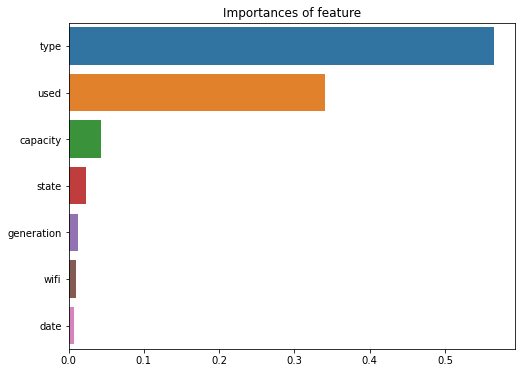

In [10]:
#각 특징의 중요도
import matplotlib.pyplot as plt
import seaborn as sns

importance = estimator.feature_importances_
ftr_importances = pd.Series(importance, index = x_train.columns)
ftr = ftr_importances.sort_values(ascending=False)

plt.figure(figsize=(8,6))
plt.title('Importances of feature')
sns.barplot(x=ftr, y=ftr.index)
plt.show()